# 🧹 Forecasting Migration Flows — **Notebook 01: Data Preparation & Cleaning**

| **Author** | Golib Sanaev |
|---|---|
| **Project** | Forecasting Migration Flows with Machine Learning |
| **Created** | 2025-09-23 |
| **Last Updated** | 2025-10-12 |

---

### 🎯 Purpose
Prepare the datasets required for forecasting international migration flows. This notebook covers:
- Environment and dependency setup  
- Separation of World Bank and HDI data into **country-level** and **aggregate-level** subsets  
- **Data availability** checks and **missing value** analysis  
- Cleaning and imputing missing values for country and aggregate datasets  
- Export of final cleaned datasets for downstream analysis and modeling

---

## 📑 Table of Contents
1. [Setup](#1-setup)  
2. [Separate Countries and Aggregates](#2-separate-countries-and-aggregates)  
 2.1. [Save Separate Datasets](#21-save-separate-datasets)  
3. [Load Cleaned Datasets for Analysis](#3-load-cleaned-datasets-for-analysis)  
4. [Data Availability and Completeness](#4-data-availability-and-completeness)  
 4.1. [Utility Functions](#41-utility-functions)  
 4.2. [Data Cleaning and Imputation for Countries](#42-data-cleaning-and-imputation-for-countries)  
 4.3. [Data Cleaning and Imputation for Aggregates](#43-data-cleaning-and-imputation-for-aggregates)  
 4.4. [Final Checks and Export](#44-final-checks-and-export)  
 4.5. [Dropped Countries Diagnostic](#45-dropped-countries-diagnostic)

---


## ⚙️ 1. Setup

In this section:
- Import all required libraries  
- Configure dataset paths and environment settings  

---


In [25]:
# === Import Required Libraries ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Display and Plot Settings ===
pd.set_option("display.max_columns", None)
plt.rcParams.update({"figure.figsize": (10, 4), "figure.dpi": 120})

# === Dataset Path Configuration ===
DATA_PATH = Path("../data/processed/wdi_hdr.csv")
FALLBACK_PATH = Path("/mnt/data/wdi_hdr.csv")

if not DATA_PATH.exists() and FALLBACK_PATH.exists():
    DATA_PATH = FALLBACK_PATH
    print(f"[INFO] Using fallback path: {DATA_PATH}")
else:
    print(f"[INFO] Using data path: {DATA_PATH}")

# === Load Dataset ===
df = pd.read_csv(DATA_PATH)
print(f"[INFO] Loaded data with shape: {df.shape}")

# === Preview ===
df.head()

[INFO] Using data path: ../data/processed/wdi_hdr.csv
[INFO] Loaded data with shape: (9310, 21)


,Country Name,Country Code,year,pop_density,mobile_subs,exports_gdp,imports_gdp,gdp_growth,gdp_per_capita,under5_mortality,unemployment,net_migration,adol_fertility,life_expectancy,fertility_rate,pop_growth,population,urban_pop_growth,hdi,Region,IncomeGroup
0,Afghanistan,AFG,1990,18.468424,0.0,NaN,NaN,NaN,NaN,180.7,NaN,-458737.0,139.376,45.118,7.576,1.434588,12045660.0,1.855712,0.285,Middle East & North Africa,Low income
1,Afghanistan,AFG,1991,18.764667,0.0,NaN,NaN,NaN,NaN,174.4,8.070,32782.0,145.383,45.521,7.631,1.591326,12238879.0,2.010729,0.291,Middle East & North Africa,Low income
2,Afghanistan,AFG,1992,20.359343,0.0,NaN,NaN,NaN,NaN,168.5,8.011,1197329.0,147.499,46.569,7.703,8.156419,13278974.0,8.574058,0.301,Middle East & North Africa,Low income
3,Afghanistan,AFG,1993,22.910893,0.0,NaN,NaN,NaN,NaN,163.0,7.888,1149684.0,149.461,51.021,7.761,11.807259,14943172.0,12.223160,0.311,Middle East & North Africa,Low income
4,Afghanistan,AFG,1994,24.915741,0.0,NaN,NaN,NaN,NaN,157.7,7.822,315206.0,156.835,50.969,7.767,8.388730,16250794.0,8.807544,0.305,Middle East & North Africa,Low income


## 🌍 2. Separate Countries and Aggregates

In this step:
- Filter the raw dataset into two subsets:  
  - `countries_only.csv`  
  - `aggregates_only.csv`  
- Save both processed files into the `../data/processed/` directory  

---


In [26]:
# === Identify WDI Aggregate vs. Country Entries ===

# --- Define Keywords and Exceptions ---
AGG_KEYWORDS = [
    "income", "countries", "world", "union", "region", "states",
    "area", "members", "bank", "monetary", "zone",
    "africa", "asia", "america", "europe", "latin", "sub-saharan",
    "middle east", "north", "south", "central",
    "develop", "fragile", "caribbean", "pacific",
    "early-demographic dividend", "late-demographic dividend",
    "post-demographic dividend", "pre-demographic dividend",
    "ibrd only", "ida & ibrd total", "ida blend",
    "ida only", "ida total"
]

EXCEPTIONS = {
    "american samoa",
    "central african republic",
    "south africa",
    "north macedonia",
    "south sudan",
    "united states",
    "korea, rep.",
    "korea, dem. people's rep.",
    "dominican republic",
    "czechia",
    "west bank and gaza",
    "british virgin islands",
    "cayman islands",
    "channel islands"
}

# --- Helper Function ---
def is_aggregate(name: str) -> bool:
    """Return True if the entity name corresponds to an aggregate or regional group."""
    if not isinstance(name, str):
        return False
    low = name.lower().strip()
    if low in EXCEPTIONS:
        return False
    return any(k in low for k in AGG_KEYWORDS)

# --- Apply Classification ---
if "Country Name" in df.columns:
    df["is_aggregate"] = df["Country Name"].apply(is_aggregate)

# --- Summarize Results ---
agg_counts = df["is_aggregate"].value_counts(dropna=False)

countries = (
    df.loc[~df["is_aggregate"], "Country Name"]
      .drop_duplicates().sort_values().to_list()
)
aggregates = (
    df.loc[df["is_aggregate"], "Country Name"]
      .drop_duplicates().sort_values().to_list()
)

print(f"[INFO] Number of countries: {len(countries)}")
print(f"[INFO] Number of aggregates: {len(aggregates)}")

[INFO] Number of countries: 217
[INFO] Number of aggregates: 49


### 💾 2.1 Save Separate Datasets

Save the filtered subsets (`countries_only.csv` and `aggregates_only.csv`) for later analysis and validation.

---


In [27]:
# === Split and Save Separate Datasets ===

# --- Split into Countries and Aggregates ---
countries_df = df.loc[~df["is_aggregate"]].copy()
aggregates_df = df.loc[df["is_aggregate"]].copy()

# --- Drop Irrelevant Columns for Aggregates ---
aggregates_df = aggregates_df.drop(columns=["Region", "IncomeGroup", "hdi"], errors="ignore")

# --- Clean Up Helper Column ---
for d in [countries_df, aggregates_df]:
    if "is_aggregate" in d.columns:
        d.drop(columns="is_aggregate", inplace=True)

# --- Save Processed Datasets ---
countries_df.to_csv("../data/processed/countries_only.csv", index=False)
aggregates_df.to_csv("../data/processed/aggregates_only.csv", index=False)

print("[INFO] Saved cleaned datasets:")
print("       • countries_only.csv")
print("       • aggregates_only.csv")

[INFO] Saved cleaned datasets:
       • countries_only.csv
       • aggregates_only.csv


## 📂 3. Load Cleaned Datasets for Analysis

In this section:
- Load the previously saved **country-only** and **aggregate-only** datasets  
- Confirm their shapes, columns, and basic completeness  
- Prepare data for availability and completeness analysis  

---


In [28]:
# === Load Cleaned Datasets for Analysis ===

# --- Read Processed Files ---
countries_df = pd.read_csv("../data/processed/countries_only.csv")
aggregates_df = pd.read_csv("../data/processed/aggregates_only.csv")

# --- Confirm Shapes ---
print(f"[INFO] Countries-only shape: {countries_df.shape}")
print(f"[INFO] Aggregates-only shape: {aggregates_df.shape}")

# --- Working Copies ---
df_country = countries_df.copy()  # Primary dataset for country-level analysis
df_agg = aggregates_df.copy()     # Aggregate-level dataset for reference

[INFO] Countries-only shape: (7595, 21)
[INFO] Aggregates-only shape: (1715, 18)


## 📊 4. Data Availability and Completeness

### 🧩 4.1 Utility Functions

Define reusable helper functions for:
- Missing value visualization → `summarize_missing()`  
- Entity filtering → `drop_empty_entities()`  
- Variable-group imputation → `impute_variables()`  

---

In [29]:
# === Utility Function: summarize_missing ===

def summarize_missing(df, group_col=None, entity_label="Country"):
    """
    Print a basic dataset summary, including shape, columns, and missing value counts.
    Optionally visualize missingness by year for time-series data.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to summarize.
    group_col : str, optional
        If set to 'year', plots missingness by year.
    entity_label : str, default='Country'
        Label used in titles and print outputs.
    """
    print(f"[INFO] {entity_label}-level dataset shape: {df.shape}")
    print(f"[INFO] Columns: {list(df.columns)}")

    missing_summary = df.isna().sum().sort_values(ascending=False)
    print("\n[INFO] Missing values per column:")
    print(missing_summary)

    if group_col == "year":
        missing_by_year = df.groupby("year").apply(lambda x: x.isna().mean())
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            missing_by_year.T,
            cmap="viridis",
            cbar_kws={"label": "% Missing"},
        )
        plt.xlabel("Year")
        plt.ylabel("Indicator")
        plt.title(f"Missing Values per Indicator per Year ({entity_label}-level)")
        plt.show()

In [30]:
# === Utility Function: drop_empty_entities ===

def drop_empty_entities(df, entity_col, indicators):
    """
    Drop entities (countries or aggregates) that have all missing values for any indicator.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing entities and indicators.
    entity_col : str
        Column name representing entity identifiers (e.g., 'Country Name').
    indicators : list
        List of indicator columns to evaluate for missingness.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with entities containing at least one non-missing value per indicator.
    """
    entities_to_drop = set()
    
    for col in indicators:
        no_data = df.groupby(entity_col)[col].apply(lambda x: x.isna().all())
        missing_entities = no_data[no_data].index.tolist()
        if missing_entities:
            print(f"[INFO] {col}: {len(missing_entities)} {entity_col}s with no data")
            entities_to_drop.update(missing_entities)
    
    print(f"\n[INFO] Total {entity_col}s to drop (missing any indicator): {len(entities_to_drop)}")
    df = df[~df[entity_col].isin(entities_to_drop)].reset_index(drop=True)
    
    return df

In [31]:
# === Utility Function: impute_variables ===

def impute_variables(
    df,
    entity_col,
    time_series_vars,
    bounded_vars,
    trade_vars,
    net_migration_var,
    population_density_var,
    remaining_missing=None,
):
    """
    Apply multi-stage imputation for different groups of variables.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset to impute.
    entity_col : str
        Column name identifying entities (e.g., countries).
    time_series_vars : list
        Variables with time-dependent values to interpolate linearly.
    bounded_vars : list
        Variables with lower bounds (e.g., rates, ratios) to interpolate and clip at zero.
    trade_vars : list
        Trade-related variables to interpolate and fill with median values.
    net_migration_var : list
        Migration variables to interpolate and fill with median values.
    population_density_var : list
        Variables representing population density, interpolated and clipped.
    remaining_missing : dict, optional
        Dictionary mapping columns to imputation methods ('mean' or 'median').

    Returns
    -------
    pd.DataFrame
        DataFrame with missing values imputed according to the specified strategy.
    """
    # --- Sort by Entity and Year ---
    df = df.sort_values([entity_col, "year"]).reset_index(drop=True)

    # --- Time-Series Variables ---
    for col in time_series_vars:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method="linear"))

    # --- Bounded Variables ---
    for col in bounded_vars:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method="linear"))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].clip(lower=0)

    # --- Trade Variables ---
    for col in trade_vars:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method="linear"))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].clip(lower=0)

    # --- Net Migration ---
    for col in net_migration_var:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method="linear"))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))

    # --- Population Density ---
    for col in population_density_var:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method="linear"))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].clip(lower=0)

    # --- Remaining Missing Values ---
    if remaining_missing:
        for col, method in remaining_missing.items():
            if method == "median":
                df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
            elif method == "mean":
                df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                raise ValueError(f"Unknown imputation method: {method}")

    # --- Summary ---
    print("\n[INFO] Remaining missing values after imputation:")
    print(df.isna().sum())

    return df

### 🌎 4.2 Data Cleaning and Imputation for Countries

Apply the defined utility functions to clean and impute missing values for **country-level** datasets.

---

[INFO] Country-level dataset shape: (7595, 21)
[INFO] Columns: ['Country Name', 'Country Code', 'year', 'pop_density', 'mobile_subs', 'exports_gdp', 'imports_gdp', 'gdp_growth', 'gdp_per_capita', 'under5_mortality', 'unemployment', 'net_migration', 'adol_fertility', 'life_expectancy', 'fertility_rate', 'pop_growth', 'population', 'urban_pop_growth', 'hdi', 'Region', 'IncomeGroup']

[INFO] Missing values per column:
hdi                 1655
exports_gdp         1623
imports_gdp         1623
unemployment        1246
under5_mortality     931
mobile_subs          737
gdp_per_capita       562
gdp_growth           532
pop_density          499
life_expectancy      251
fertility_rate       251
adol_fertility       251
urban_pop_growth     107
IncomeGroup          105
pop_growth            38
net_migration         35
population            35
Region                35
Country Code           0
year                   0
Country Name           0
dtype: int64


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_74977/3326964318.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_year = df.groupby("year").apply(lambda x: x.isna().mean())


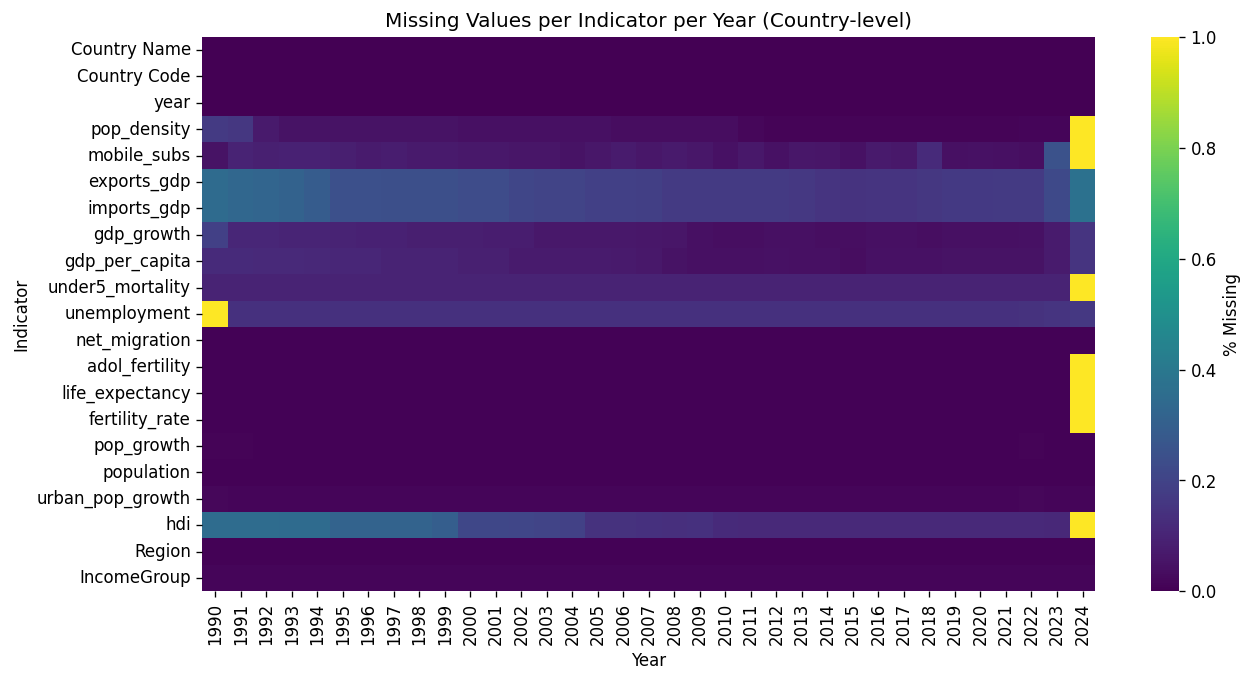

[INFO] gdp_growth: 4 Country Names with no data
[INFO] gdp_per_capita: 6 Country Names with no data
[INFO] pop_growth: 1 Country Names with no data
[INFO] urban_pop_growth: 3 Country Names with no data
[INFO] adol_fertility: 1 Country Names with no data
[INFO] fertility_rate: 1 Country Names with no data
[INFO] life_expectancy: 1 Country Names with no data
[INFO] mobile_subs: 4 Country Names with no data
[INFO] under5_mortality: 21 Country Names with no data
[INFO] hdi: 24 Country Names with no data
[INFO] exports_gdp: 25 Country Names with no data
[INFO] imports_gdp: 25 Country Names with no data
[INFO] net_migration: 1 Country Names with no data
[INFO] pop_density: 2 Country Names with no data
[INFO] unemployment: 30 Country Names with no data

[INFO] Total Country Names to drop (missing any indicator): 49

[INFO] Remaining missing values after imputation:
Country Name         0
Country Code         0
year                 0
pop_density          0
mobile_subs          0
exports_gdp   

In [32]:
# === Data Cleaning and Imputation for Countries ===

# --- Define Variable Groups ---
time_series_vars = ['gdp_growth', 'gdp_per_capita', 'pop_growth', 'urban_pop_growth']
bounded_vars = ['adol_fertility', 'fertility_rate', 'life_expectancy', 'mobile_subs', 'under5_mortality', 'hdi']
trade_vars = ['exports_gdp', 'imports_gdp']
net_migration_var = ['net_migration']
population_density_var = ['pop_density']
remaining_missing = {
    'gdp_growth': 'median',
    'gdp_per_capita': 'median',
    'unemployment': 'median',
    'pop_growth': 'median',
    'urban_pop_growth': 'median'
}

# --- Step 1: Inspect and Visualize Missingness ---
summarize_missing(df_country, group_col='year', entity_label="Country")

# --- Step 2: Drop Countries Missing Any Entire Indicator ---
df_country = drop_empty_entities(
    df_country,
    'Country Name',
    indicators=(
        time_series_vars
        + bounded_vars
        + trade_vars
        + net_migration_var
        + population_density_var
        + ['unemployment']
    ),
)

# --- Step 3: Impute Missing Values ---
df_country = impute_variables(
    df_country,
    'Country Name',
    time_series_vars,
    bounded_vars,
    trade_vars,
    net_migration_var,
    population_density_var,
    remaining_missing,
)

# --- Step 4: Drop 2024 Due to Incompleteness ---
df_country = df_country[df_country['year'] < 2024].reset_index(drop=True)
print(f"[INFO] Final shape after dropping 2024: {df_country.shape}")

In [33]:
# === Manual Metadata Correction ===

# --- Fix Missing IncomeGroup for Ethiopia (metadata gap) ---
df_country.loc[df_country["Country Name"] == "Ethiopia", "IncomeGroup"] = "Low income"

print("[INFO] Filled missing IncomeGroup for Ethiopia.")

[INFO] Filled missing IncomeGroup for Ethiopia.


### 🌐 4.3 Data Cleaning and Imputation for Aggregates

Apply the same cleaning and imputation logic to **aggregate-level** datasets.

---


[INFO] Aggregate-level dataset shape: (1715, 18)
[INFO] Columns: ['Country Name', 'Country Code', 'year', 'pop_density', 'mobile_subs', 'exports_gdp', 'imports_gdp', 'gdp_growth', 'gdp_per_capita', 'under5_mortality', 'unemployment', 'net_migration', 'adol_fertility', 'life_expectancy', 'fertility_rate', 'pop_growth', 'population', 'urban_pop_growth']

[INFO] Missing values per column:
exports_gdp         188
mobile_subs         156
imports_gdp         101
pop_density          98
under5_mortality     83
unemployment         83
life_expectancy      49
fertility_rate       49
adol_fertility       49
gdp_growth           16
gdp_per_capita       14
population            0
pop_growth            0
Country Name          0
net_migration         0
Country Code          0
year                  0
urban_pop_growth      0
dtype: int64


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_74977/3326964318.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_year = df.groupby("year").apply(lambda x: x.isna().mean())


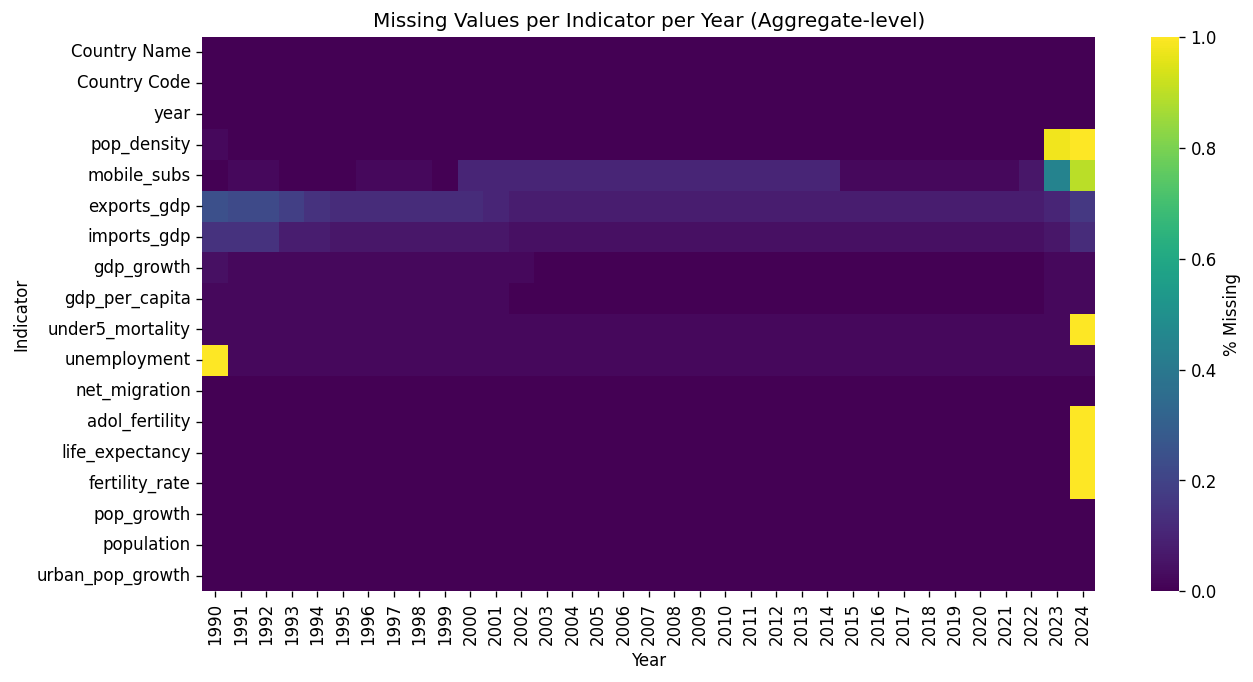

[INFO] under5_mortality: 1 Country Names with no data
[INFO] exports_gdp: 4 Country Names with no data
[INFO] imports_gdp: 2 Country Names with no data
[INFO] unemployment: 1 Country Names with no data

[INFO] Total Country Names to drop (missing any indicator): 5

[INFO] Remaining missing values after imputation:
Country Name        0
Country Code        0
year                0
pop_density         0
mobile_subs         0
exports_gdp         0
imports_gdp         0
gdp_growth          0
gdp_per_capita      0
under5_mortality    0
unemployment        0
net_migration       0
adol_fertility      0
life_expectancy     0
fertility_rate      0
pop_growth          0
population          0
urban_pop_growth    0
dtype: int64
[INFO] Final shape after dropping 2024: (1496, 18)


In [34]:
# === Data Cleaning and Imputation for Aggregates ===

# --- Define Variable Groups (HDI omitted — not available for aggregates) ---
bounded_vars = ['adol_fertility', 'fertility_rate', 'life_expectancy', 'mobile_subs', 'under5_mortality']

# --- Step 1: Inspect and Visualize Missingness ---
summarize_missing(df_agg, group_col='year', entity_label="Aggregate")

# --- Step 2: Drop Aggregates Missing Any Entire Indicator ---
df_agg = drop_empty_entities(
    df_agg,
    'Country Name',
    indicators=(
        time_series_vars
        + bounded_vars
        + trade_vars
        + net_migration_var
        + population_density_var
        + ['unemployment']
    ),
)

# --- Step 3: Impute Missing Values ---
df_agg = impute_variables(
    df_agg,
    'Country Name',
    time_series_vars,
    bounded_vars,
    trade_vars,
    net_migration_var,
    population_density_var,
    remaining_missing,
)

# --- Step 4: Drop 2024 Due to Incompleteness ---
df_agg = df_agg[df_agg['year'] < 2024].reset_index(drop=True)
print(f"[INFO] Final shape after dropping 2024: {df_agg.shape}")

### ✅ 4.4 Final Checks and Export

Before moving to the next notebook (EDA and exploration), verify that all missing values have been properly handled and export the final cleaned datasets for downstream use.

---


In [35]:
# === Final Checks and Export ===

# --- Summary of Dataset Dimensions ---
df_country_num_countries = df_country["Country Name"].nunique()
df_agg_num_countries = df_agg["Country Name"].nunique()
num_years = df_country["year"].nunique()

print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)
print(f"Countries:       {df_country_num_countries}")
print(f"Aggregates:      {df_agg_num_countries}")
print(f"Years:           {num_years}")
print(f"Expected rows:   {df_country_num_countries * num_years:,}")
print(f"Actual rows:     {len(df_country):,}")
print("=" * 60)

# --- Define Processed Data Directory ---
DATA_DIR = Path("../data/processed")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# --- Check Remaining Missing Values ---
print("\n[INFO] Remaining missing values:")
print(f"Countries:  {df_country.isna().sum().sum()}")
print(f"Aggregates: {df_agg.isna().sum().sum()}")

# --- Save Cleaned Datasets ---
df_country.to_csv(DATA_DIR / "countries_clean.csv", index=False)
df_agg.to_csv(DATA_DIR / "aggregates_clean.csv", index=False)

print("\n[INFO] Cleaned datasets saved successfully to:")
for path in [DATA_DIR / "countries_clean.csv", DATA_DIR / "aggregates_clean.csv"]:
    if path.exists():
        size_kb = path.stat().st_size / 1024
        print(f"   • {path.name} ({size_kb:.1f} KB)")

DATASET SUMMARY
Countries:       168
Aggregates:      44
Years:           34
Expected rows:   5,712
Actual rows:     5,712

[INFO] Remaining missing values:
Countries:  0
Aggregates: 0

[INFO] Cleaned datasets saved successfully to:
   • countries_clean.csv (1399.3 KB)
   • aggregates_clean.csv (425.7 KB)


### 🧭 4.5 Dropped Countries Diagnostic

After exporting the cleaned datasets, verify which countries were removed during preprocessing.  
This step ensures transparency in data coverage and documents entities excluded due to missing values.

Most dropped entries correspond to **microstates**, **territories**, or **regions** with incomplete reporting.  
Only a few larger economies (e.g., **Nigeria**, **Venezuela**) were excluded due to insufficient key indicators.

---


In [36]:
# === Dropped Countries Diagnostic ===

# --- Load Pre- and Post-Cleaning Datasets ---
pre_clean = pd.read_csv("../data/processed/countries_only.csv")
post_clean = pd.read_csv("../data/processed/countries_clean.csv")

# --- Identify Dropped Countries ---
before_countries = set(pre_clean["Country Name"].unique())
after_countries = set(post_clean["Country Name"].unique())
dropped_countries = sorted(list(before_countries - after_countries))

# --- Summary Report ---
print("=" * 60)
print("DROPPED COUNTRIES DIAGNOSTIC")
print("=" * 60)
print(f"[INFO] Total dropped: {len(dropped_countries)}")
print(f"[INFO] Dropped list: {dropped_countries}")
print("=" * 60)

DROPPED COUNTRIES DIAGNOSTIC
[INFO] Total dropped: 49
[INFO] Dropped list: ['American Samoa', 'Andorra', 'Antigua and Barbuda', 'Aruba', 'Barbados', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Channel Islands', 'Curacao', 'Dominica', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Hong Kong SAR, China', 'Isle of Man', 'Kiribati', "Korea, Dem. People's Rep.", 'Kosovo', 'Liberia', 'Liechtenstein', 'Macao SAR, China', 'Malawi', 'Marshall Islands', 'Micronesia, Fed. Sts.', 'Monaco', 'Myanmar', 'Nauru', 'New Caledonia', 'Nigeria', 'Not classified', 'Palau', 'Puerto Rico (US)', 'San Marino', 'Sao Tome and Principe', 'Seychelles', 'Sint Maarten (Dutch part)', 'St. Kitts and Nevis', 'St. Lucia', 'St. Martin (French part)', 'St. Vincent and the Grenadines', 'Trinidad and Tobago', 'Turks and Caicos Islands', 'Tuvalu', 'Venezuela, RB', 'Virgin Islands (U.S.)']


In [37]:
# === Classification of Dropped Entities ===

# --- Categorize Dropped Countries ---
microstates = [
    x for x in dropped_countries if x in [
        "Andorra", "Liechtenstein", "Monaco", "San Marino", "Malta"
    ]
]

territories = [
    x for x in dropped_countries if any(k in x for k in [
        "Islands", "SAR", "Virgin", "Polynesia", "Samoa", "Guam", "Puerto Rico",
        "Curacao", "Aruba", "Cayman", "Maarten", "Caledonia", "Man"
    ])
]

small_states = [
    x for x in dropped_countries if x in [
        "Antigua and Barbuda", "Barbados", "Grenada", "Seychelles", "St. Lucia",
        "St. Kitts and Nevis", "St. Vincent and the Grenadines", "Trinidad and Tobago"
    ]
]

isolated = [
    x for x in dropped_countries if x in [
        "Korea, Dem. People's Rep.", "Kosovo"
    ]
]

major_missing = [
    x for x in dropped_countries if x in [
        "Nigeria", "Venezuela, RB", "Myanmar", "Malawi"
    ]
]

# --- Build Summary Table ---
summary = pd.DataFrame({
    "Category": [
        "Microstates",
        "Territories / SARs",
        "Small island states",
        "Isolated / unreporting",
        "Major countries with missing data",
    ],
    "Count": [
        len(microstates),
        len(territories),
        len(small_states),
        len(isolated),
        len(major_missing),
    ],
})

print("\n[INFO] Classification summary:")
display(summary)

# --- Save Dropped Country List ---
out_path = Path("../data/processed/dropped_countries.csv")
pd.DataFrame({"Dropped Country": dropped_countries}).to_csv(out_path, index=False)
print(f"[INFO] Dropped-country list saved to: {out_path.name}")



[INFO] Classification summary:


,Category,Count
0,Microstates,4
1,Territories / SARs,18
2,Small island states,8
3,Isolated / unreporting,2
4,Major countries with missing data,4


[INFO] Dropped-country list saved to: dropped_countries.csv


## 🏁 Notebook Summary & Next Steps

In this notebook, we:
- Prepared and cleaned the **World Bank** and **HDI** datasets  
- Separated **country-level** and **aggregate-level** data  
- Conducted **missing value diagnostics** and **multi-stage imputations**  
- Exported finalized cleaned datasets ready for exploratory analysis and modeling  
- Documented dropped entities for full transparency  

**Next Notebook → [Notebook 02 – Exploratory Data Analysis (EDA)](#)**  
The following notebook explores statistical characteristics, correlations, and temporal patterns in the cleaned datasets to inform feature engineering and model design.

---
